In [1]:
import warnings

import numpy as np
import pandas as pd

# Импорт необходимых модулей
from scripts.calibrate_models import calibrate_fx_model, calibrate_models
from scripts.compare_models import compare_models, create_model
from scripts.simulate_model import simulate_model
from src.visualization.plots import plot_fx_analysis, plot_historical_data, plot_simulation
from src.visualization.stats import print_best_params, print_statistics

warnings.filterwarnings("ignore")

# SORF

SOFR отражает стоимость overnight-кредитования под залог казначейских ценных бумаг

In [2]:
raw_sofr_df = pd.read_excel("data/us-sofr.xlsx")
raw_sofr_df = raw_sofr_df.rename(columns={"Effective Date": "Date", "Rate (%)": "Rate"})[
    ["Date", "Rate"]
]
raw_sofr_df["Date"] = pd.to_datetime(raw_sofr_df["Date"])
raw_sofr_df["Rate"] = raw_sofr_df["Rate"] / 100

Статистика и график исторических данных SOFR, показывающий динамику ставки за анализируемый период.

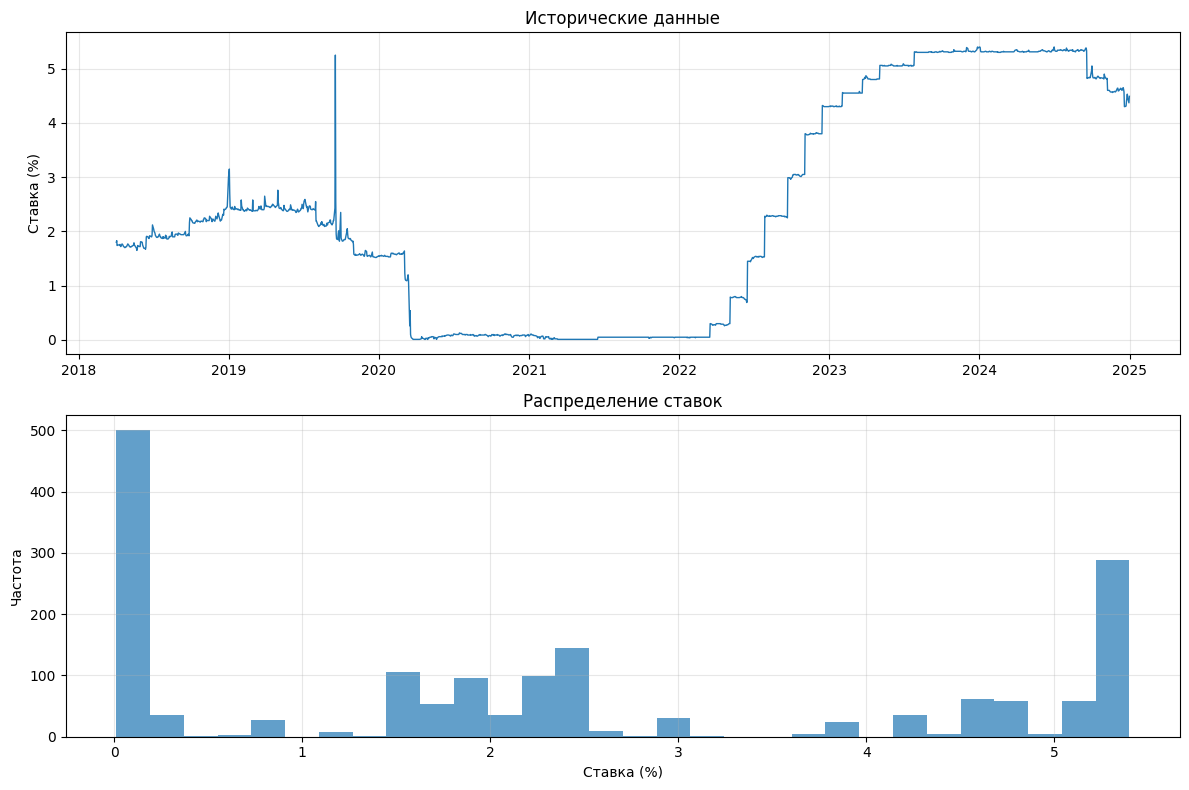

In [3]:
plot_historical_data(raw_sofr_df)

Определение временных параметров анализа
В качестве исторических данных для калибровки параметров модели выбран период с _____

Горизонт прогнозирования, релевантный для большинства финансовых инструментов, равен одному году. 

In [12]:
calc_date = pd.Timestamp("2021-12-10")
start_date = raw_sofr_df["Date"].min()  # calc_date - pd.Timedelta(days=365 * 3)
end_date = calc_date + pd.Timedelta(days=365)

In [13]:
# Фильтруем данные до нашей расчетной даты
sofr_hist = raw_sofr_df[
    (raw_sofr_df["Date"] >= start_date) & (raw_sofr_df["Date"] <= calc_date)
].copy()
sofr_df = sofr_hist.dropna()

# Берем ставку на расчетную дату
sofr_initial = sofr_hist[sofr_hist["Date"] == calc_date]["Rate"].values[0]
print(f"Начальная ставка SOFR на 10.12.2021: {sofr_initial * 100:.4f}%")

Начальная ставка SOFR на 10.12.2021: 0.0500%


СТАТИСТИКА ДАННЫХ (СТАВКА):
• Объем данных: 925 наблюдений
• Минимальный ставка: 0.0100 %
• Максимальный ставка: 5.2500 %
• Средний ставка: 1.1053 %
• Медиана: 1.5400 %
• Стандартное отклонение: 1.0318 %
• Коэффициент вариации: 0.9335

• 25-й перцентиль: 0.0500 %
• 75-й перцентиль: 2.1200 %
• IQR: 2.0700 %

Анализ изменений ставок:
• Среднее дневное изменение: 0.0019%
• Волатильность изменений: 0.1437%
• Макс. рост за день: 2.7000%
• Макс. падение за день: -2.8200%


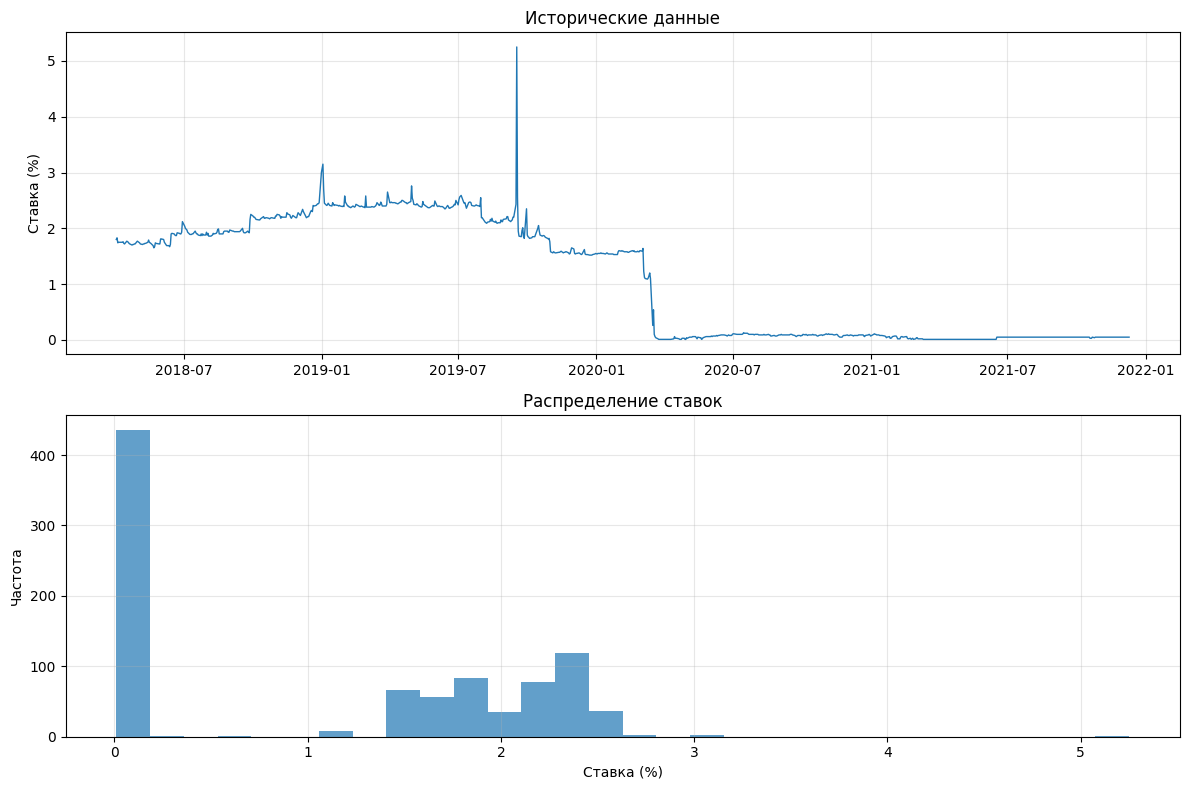

In [14]:
print_statistics(sofr_df["Rate"])
plot_historical_data(sofr_df)

Начальная ставка SOFR на 10.12.2021: 0.05% - чрезвычайно низкое значение, характерное для пост-пандемического периода.

## T-bills

T-bills - государственные облигации США. Кривая доходности по T-bills используется для расчета форвардной ставки.


In [15]:
us_g_curve_df = pd.read_excel("data/t-bills.xlsx")
us_g_curve_df = us_g_curve_df.rename(columns={"observation_date": "Date", "DGS3MO": "Rate"})[
    ["Date", "Rate"]
]
us_g_curve_df["Date"] = pd.to_datetime(us_g_curve_df["Date"])
us_g_curve_df["Rate"] = us_g_curve_df["Rate"] / 100

# Фильтруем данные до нашей расчетной даты
us_g_curve_df = us_g_curve_df[
    (us_g_curve_df["Date"] >= start_date) & (us_g_curve_df["Date"] <= calc_date)
].copy()
us_g_curve_df = us_g_curve_df.dropna()

СТАТИСТИКА ДАННЫХ (СТАВКА):
• Объем данных: 926 наблюдений
• Минимальный ставка: 0.0000 %
• Максимальный ставка: 2.4900 %
• Средний ставка: 1.1034 %
• Медиана: 1.5400 %
• Стандартное отклонение: 1.0126 %
• Коэффициент вариации: 0.9177

• 25-й перцентиль: 0.0800 %
• 75-й перцентиль: 2.0800 %
• IQR: 2.0000 %

Анализ изменений ставок:
• Среднее дневное изменение: -0.0018%
• Волатильность изменений: 0.0236%
• Макс. рост за день: 0.1100%
• Макс. падение за день: -0.2300%


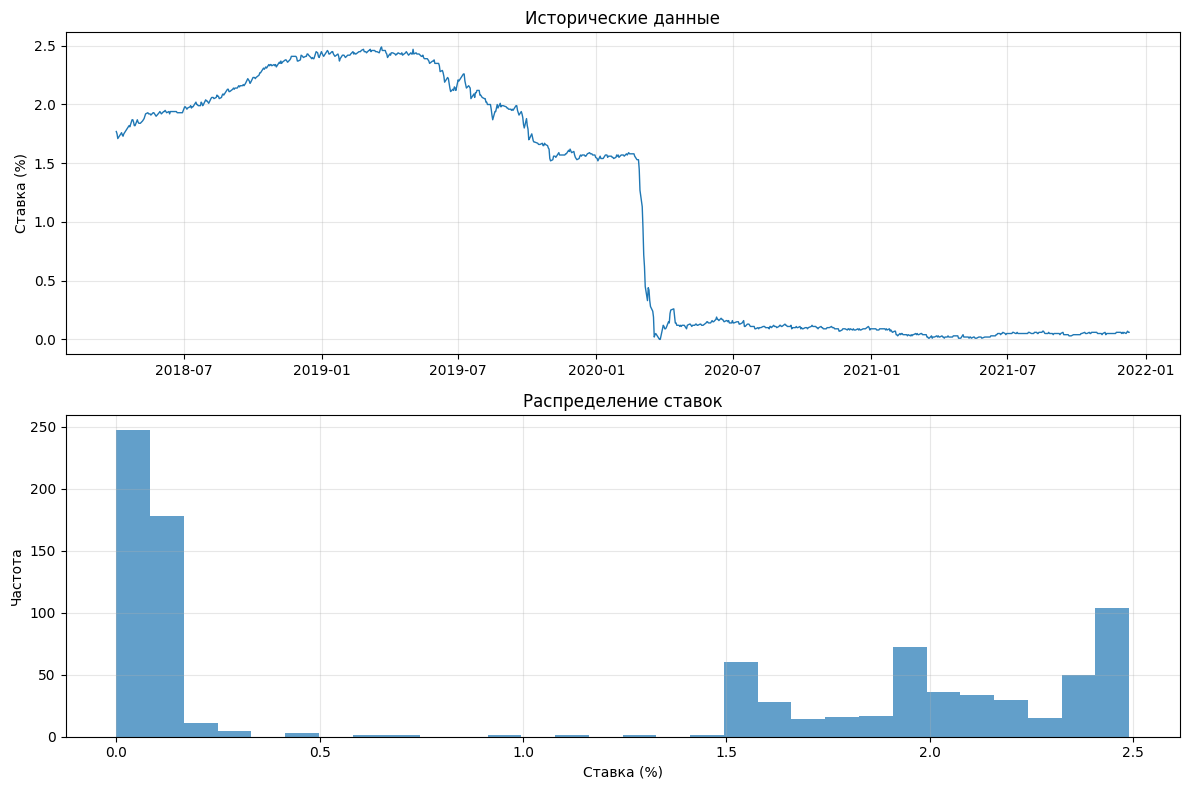

In [16]:
print_statistics(us_g_curve_df["Rate"])
plot_historical_data(us_g_curve_df)

Ключевые наблюдения по сравнению SOFR и T-bills:

- Схожий диапазон но разное распределение

- Более низкая волатильность T-bills, т.к. практически безрисковый актив

- Значительно меньшие выбросов - плавная динамика

Различия отражают разные природы инструментов. SOFR более чувствителен к краткосрочным ликвидностным шокам. T-bills отражает ожидания денежной политики


Калибровка моделей...
1. Модель с постоянной theta...
   α=0.0010, σ=0.1764, θ=0.0003
Условие Феллера: НЕ ВЫПОЛНЕНО (2αθ = 0.000001 ≤ σ² = 0.031107)
2. Модель с theta на основе G-кривой ...
   На основе G-кривой, метод: spline
Условие Феллера: НАРУШЕНО В НЕКОТОРЫХ ТОЧКАХ
3. Модель с theta на основе G-кривой ...
   На основе G-кривой, метод: piecewise
Условие Феллера: НАРУШЕНО В НЕКОТОРЫХ ТОЧКАХ

Симуляция constant модели...


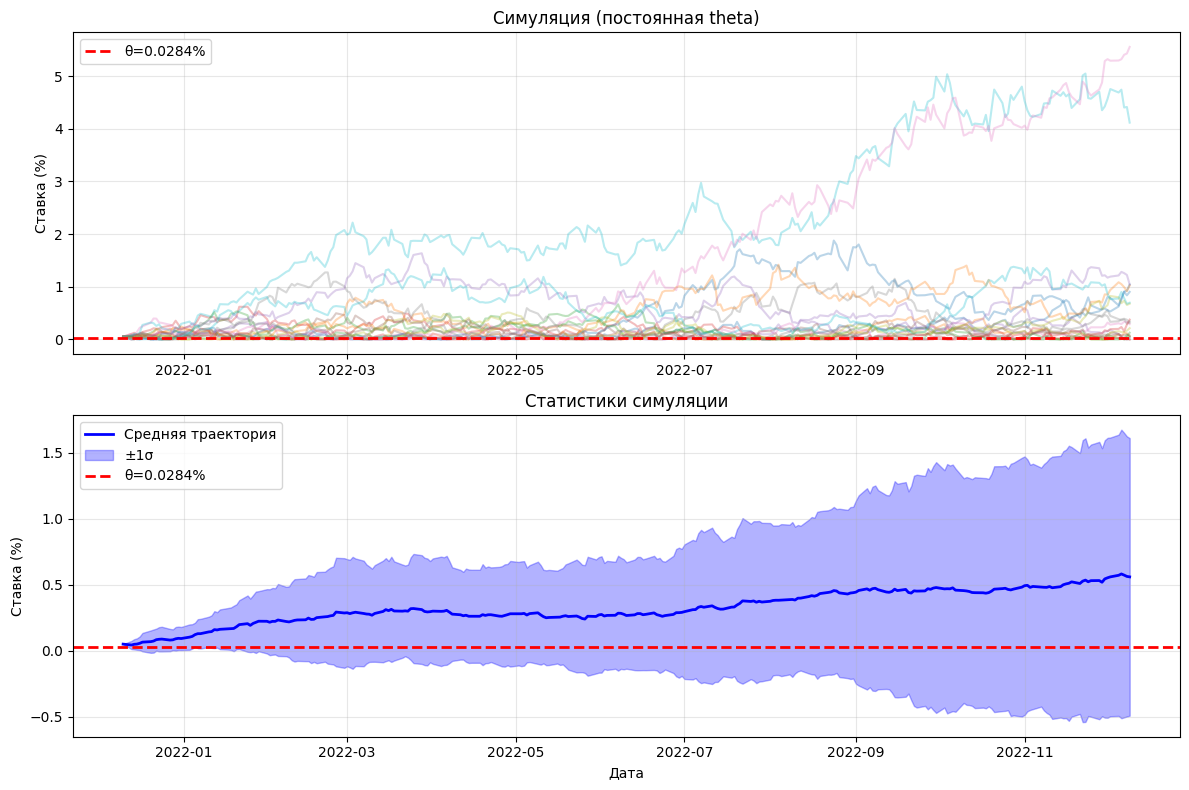


Симуляция g_curve_spline модели...


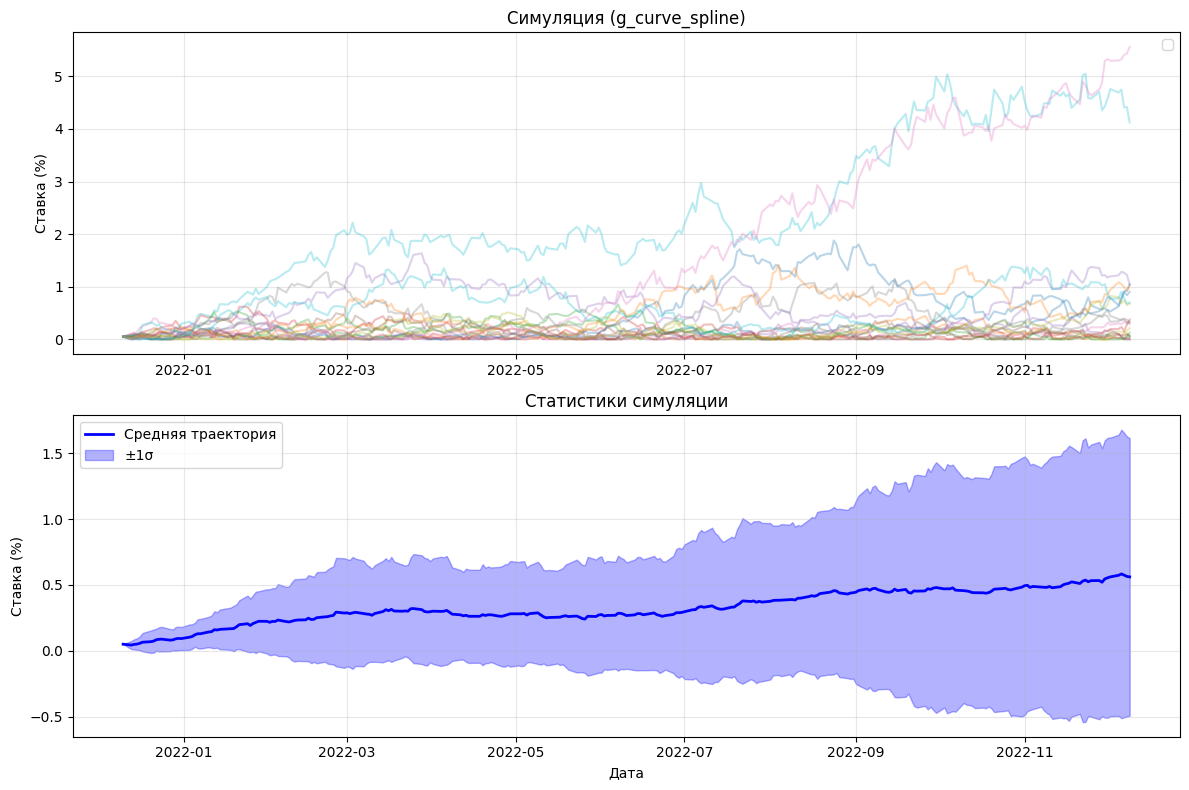


Симуляция g_curve_piecewise модели...


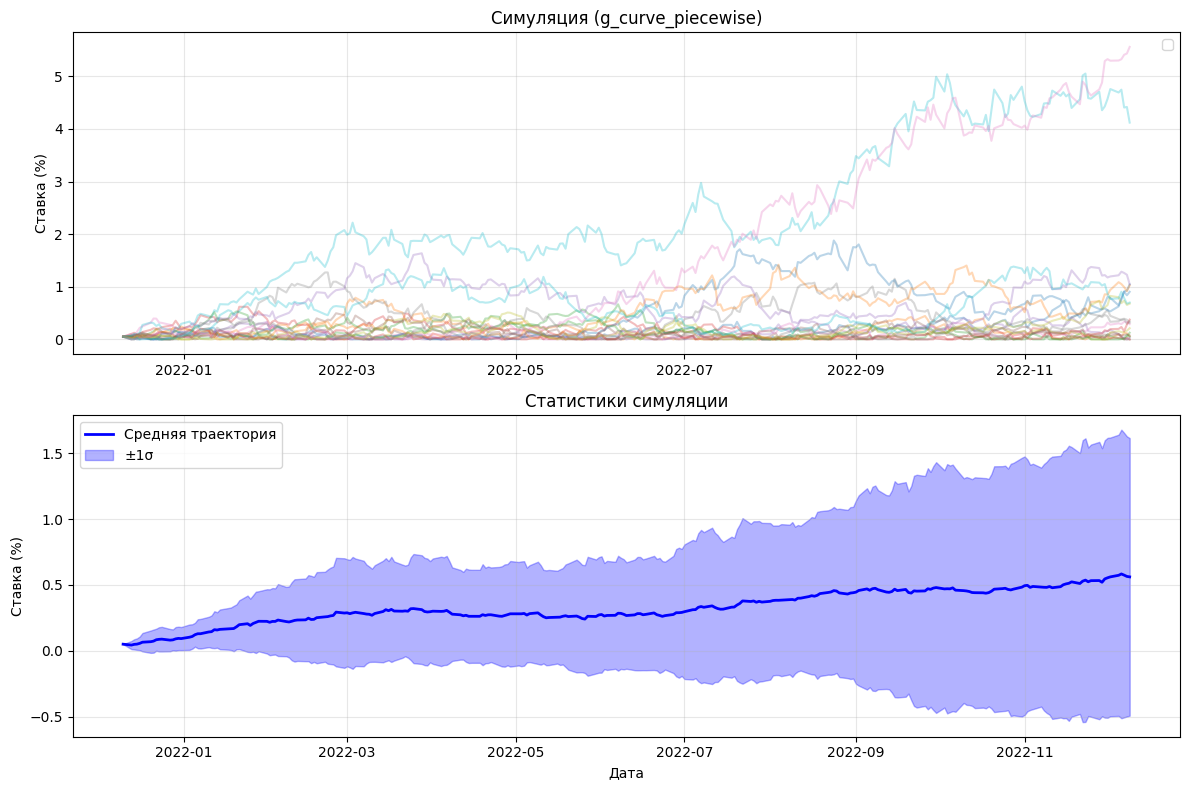

In [ ]:
# Калибровка
models = calibrate_models(sofr_df["Rate"].values, mode="sofr", g_curve_data=us_g_curve_df)

# Симуляция для каждой модели
for model_type in models:
    print(f"\nСимуляция {model_type} модели...")
    model = create_model(models[model_type], model_type)
    dates, trajectories = simulate_model(
        model=model,
        initial_value=sofr_initial,
        start_date=calc_date,
        end_date=end_date,
        n_paths=50,
        model_type="rate",
    )
    plot_simulation(dates, trajectories, model_type, models[model_type])


СРАВНЕНИЕ МОДЕЛЕЙ
Постоянная θ: LogL = 4542.8566
  θ = 0.0255 (2.55%)

Построение графиков сравнения...


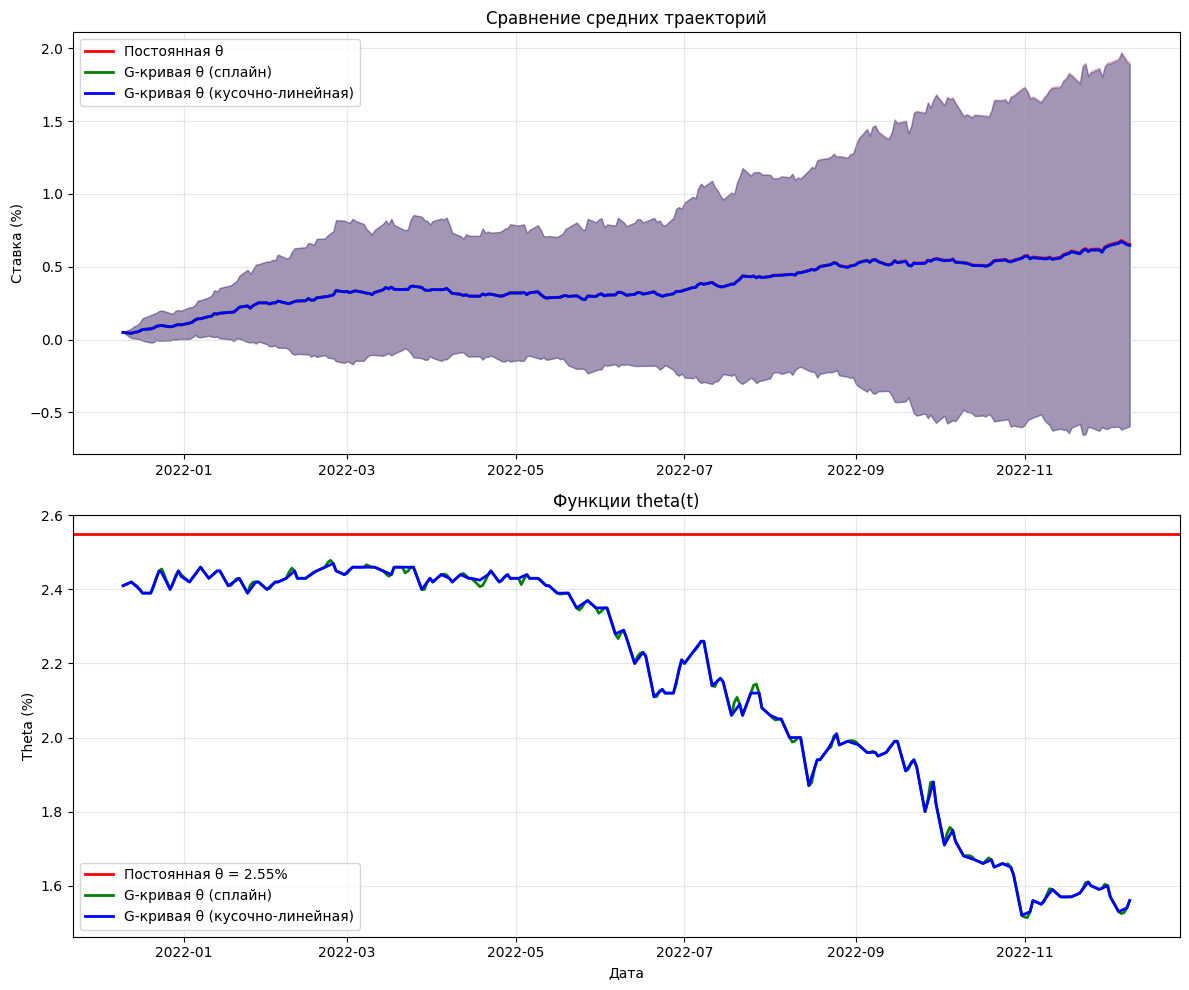

In [ ]:
best_type = compare_models(models, sofr_initial, calc_date, end_date)

In [ ]:
print_best_params(models, "g_curve_piecewise")


Параметры лучшей модели (g_curve_piecewise):
• Alpha (α): 0.0154
• Sigma (σ): 0.1942
• Theta(t): на основе G-кривой
• Диапазон G-кривой: 0.00-3.00 лет
• Ставки G-кривой: 0.00%-2.49%
• Метод интерполяции: piecewise


# RUONIO

In [ ]:
raw_ruonio_df = pd.read_excel("data/ru-ruonio.xlsx")
raw_ruonio_df = raw_ruonio_df.rename(columns={"DT": "Date", "ruo": "Rate"})[["Date", "Rate"]]
raw_ruonio_df["Date"] = pd.to_datetime(raw_ruonio_df["Date"])
raw_ruonio_df["Rate"] = raw_ruonio_df["Rate"] / 100

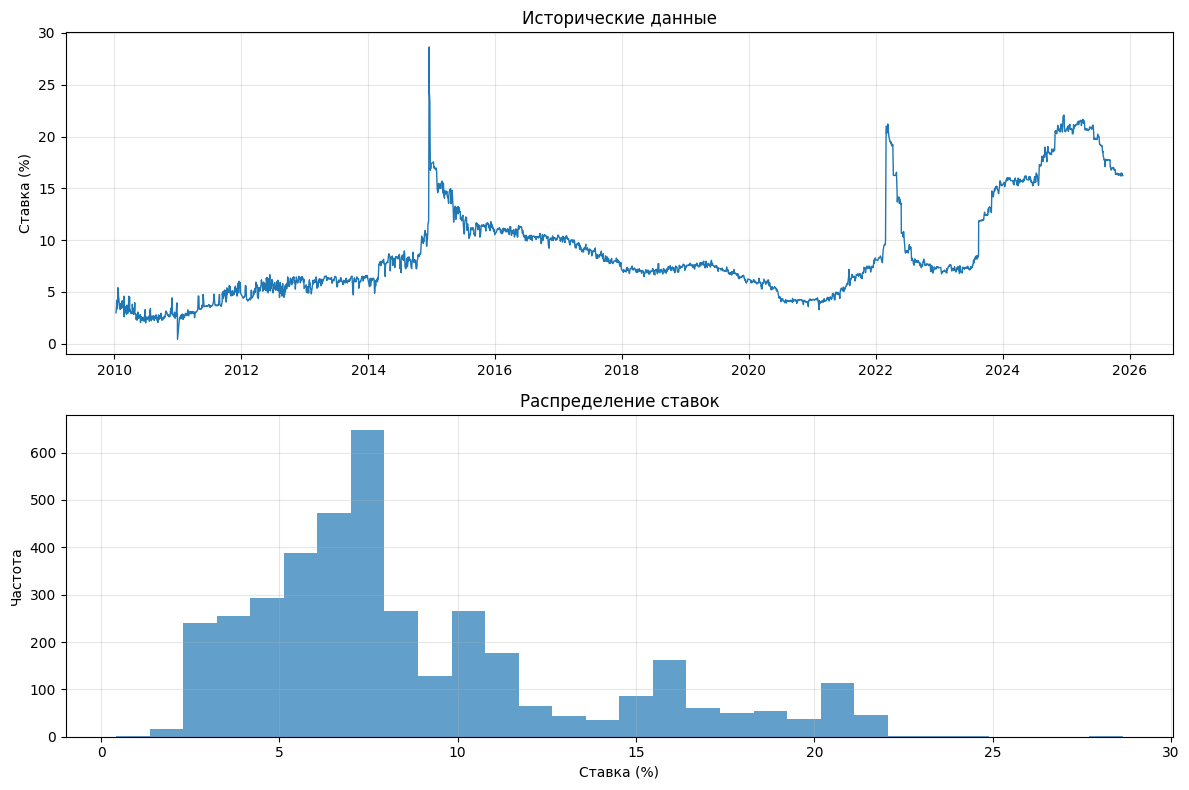

In [ ]:
plot_historical_data(raw_ruonio_df)

In [ ]:
calc_date = pd.Timestamp("2021-12-10")
start_date = calc_date - pd.Timedelta(days=365 * 3)
end_date = calc_date + pd.Timedelta(days=365)

In [ ]:
# Фильтруем данные до нашей расчетной даты
ruonio_hist = raw_ruonio_df[
    (raw_ruonio_df["Date"] >= start_date) & (raw_ruonio_df["Date"] <= calc_date)
].copy()
ruonio_df = ruonio_hist.dropna()

# Берем ставку на расчетную дату
ruonio_initial = ruonio_df[ruonio_df["Date"] == calc_date]["Rate"].values[0]
print(f"Начальная ставка SOFR на 10.12.2021: {ruonio_initial * 100:.4f}%")

Начальная ставка SOFR на 10.12.2021: 7.4500%


СТАТИСТИКА ДАННЫХ (СТАВКА):
• Объем данных: 733 наблюдений
• Минимальный ставка: 3.2800 %
• Максимальный ставка: 8.0600 %
• Средний ставка: 5.8837 %
• Медиана: 6.0200 %
• Стандартное отклонение: 1.3199 %
• Коэффициент вариации: 0.2243

• 25-й перцентиль: 4.3500 %
• 75-й перцентиль: 7.1400 %
• IQR: 2.7900 %

Анализ изменений ставок:
• Среднее дневное изменение: -0.0000%
• Волатильность изменений: 0.1376%
• Макс. рост за день: 0.5900%
• Макс. падение за день: -0.8800%


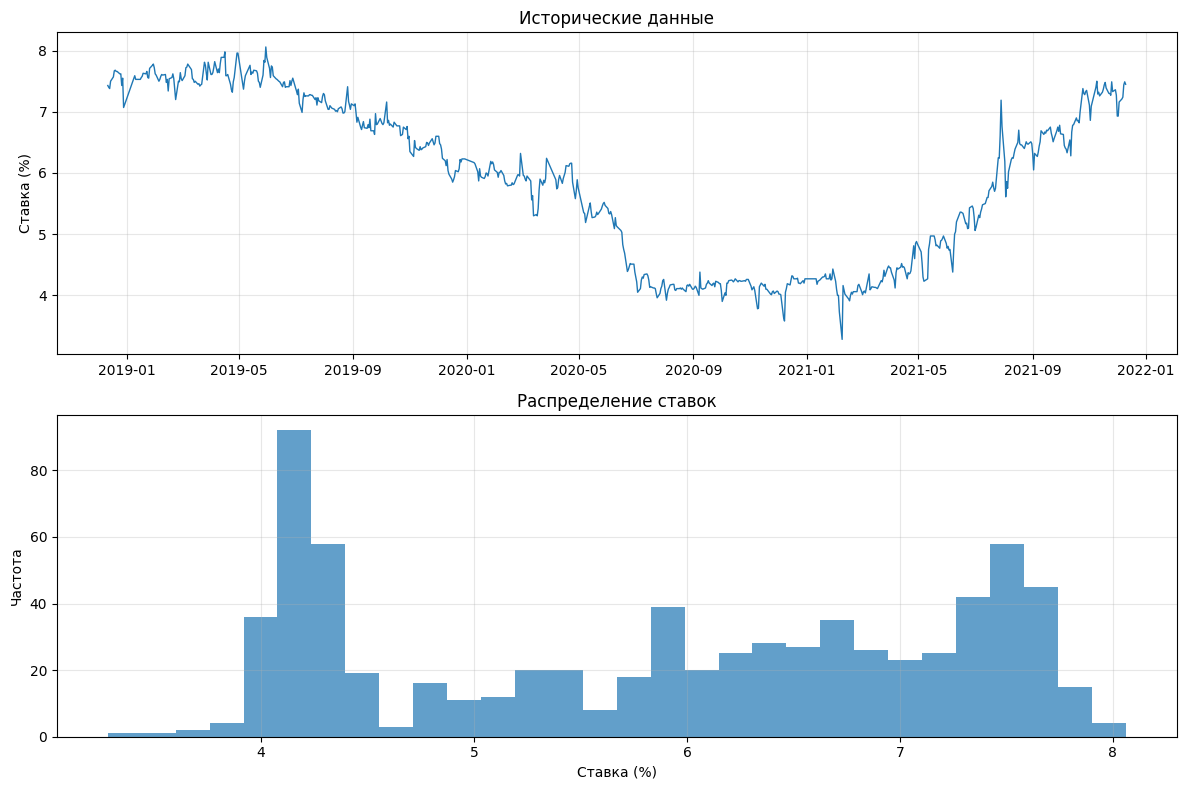

In [ ]:
print_statistics(ruonio_df["Rate"])
plot_historical_data(ruonio_df)

In [ ]:
ru_g_curve_df = pd.read_excel("data/zcyc.xlsx", decimal=",")
ru_g_curve_df = ru_g_curve_df.rename(columns={"tradedate": "Date", "period_0.25": "Rate"})[
    ["Date", "Rate"]
]
ru_g_curve_df["Date"] = pd.to_datetime(ru_g_curve_df["Date"], format="%d.%m.%Y")
ru_g_curve_df["Rate"] = ru_g_curve_df["Rate"].astype(float) / 100

# Фильтруем данные до нашей расчетной даты
ru_g_curve_df = ru_g_curve_df[
    (ru_g_curve_df["Date"] >= start_date) & (ru_g_curve_df["Date"] <= calc_date)
].copy()
ru_g_curve_df = ru_g_curve_df.dropna()

СТАТИСТИКА ДАННЫХ (СТАВКА):
• Объем данных: 758 наблюдений
• Минимальный ставка: 3.0000 %
• Максимальный ставка: 8.4700 %
• Средний ставка: 5.7635 %
• Медиана: 5.7750 %
• Стандартное отклонение: 1.2849 %
• Коэффициент вариации: 0.2229

• 25-й перцентиль: 4.5625 %
• 75-й перцентиль: 6.9700 %
• IQR: 2.4075 %

Анализ изменений ставок:
• Среднее дневное изменение: 0.0006%
• Волатильность изменений: 0.2098%
• Макс. рост за день: 1.0300%
• Макс. падение за день: -1.1100%


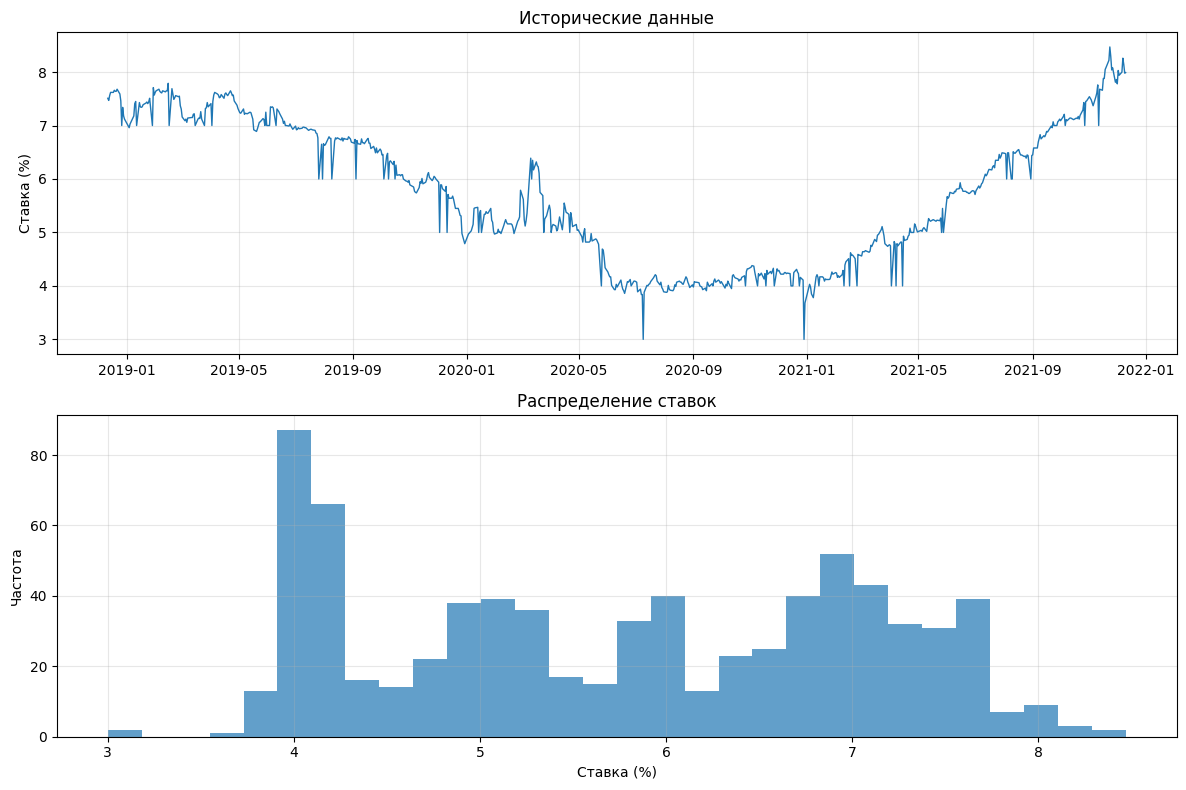

In [ ]:
print_statistics(ru_g_curve_df["Rate"])
plot_historical_data(ru_g_curve_df)


Калибровка моделей...
1. Модель с постоянной theta...
   α=1.4481, σ=0.0919, θ=0.0059
Условие Феллера: ВЫПОЛНЕНО (2αθ = 0.017021 > σ² = 0.008447)
2. Модель с theta на основе G-кривой ...
   На основе G-кривой, метод: spline
Условие Феллера: ВЫПОЛНЕНО ДЛЯ ВСЕХ t
3. Модель с theta на основе G-кривой ...
   На основе G-кривой, метод: piecewise
Условие Феллера: ВЫПОЛНЕНО ДЛЯ ВСЕХ t

Симуляция constant модели...


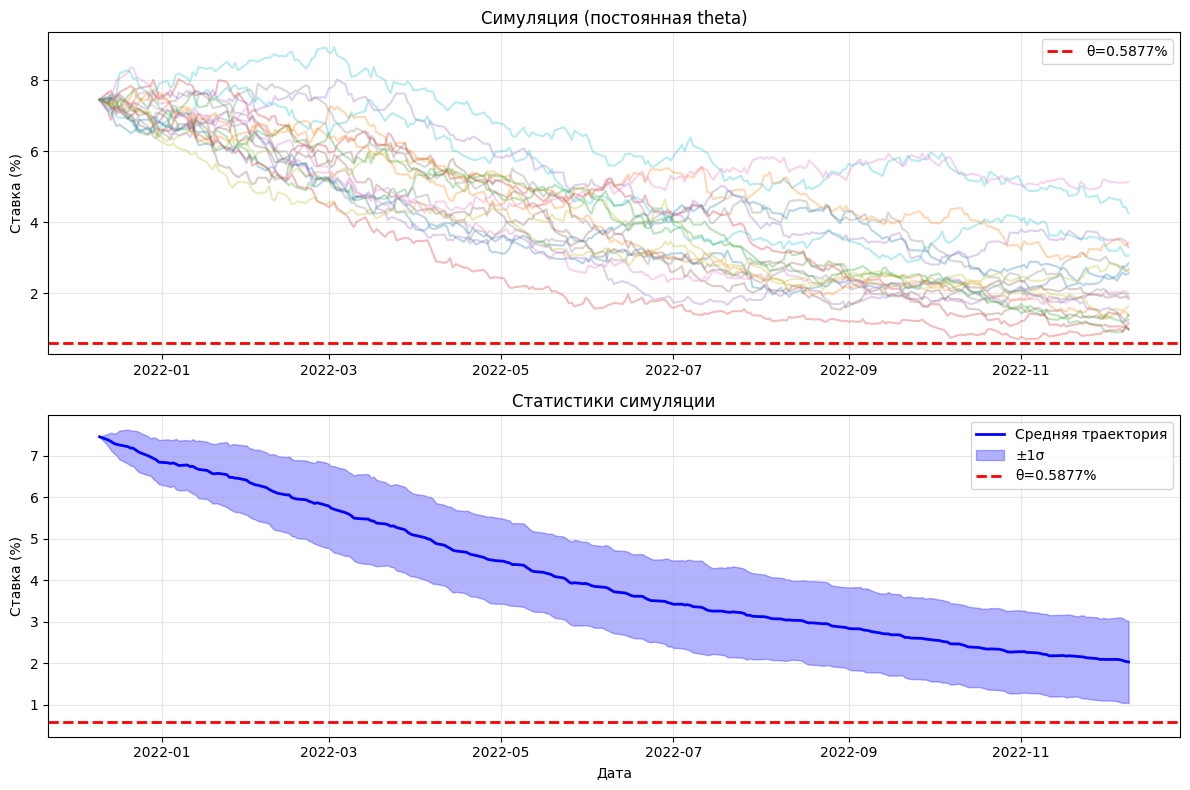


Симуляция g_curve_spline модели...


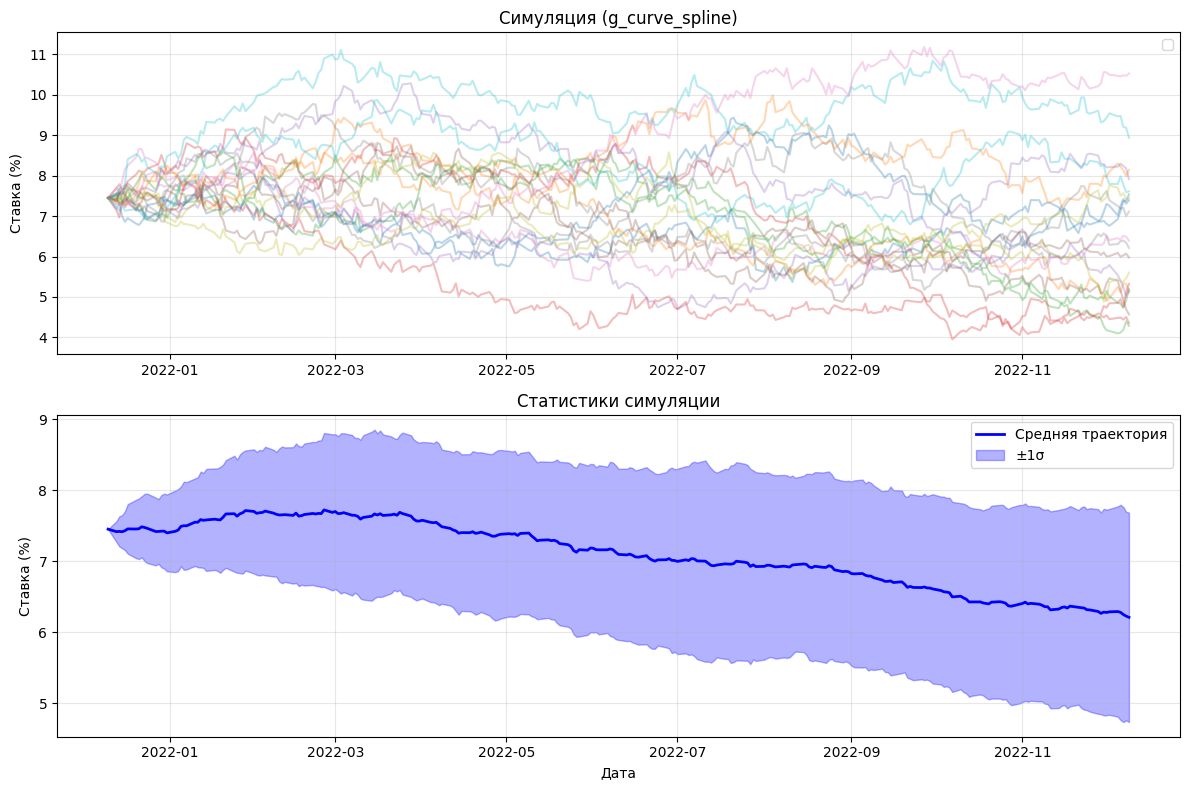


Симуляция g_curve_piecewise модели...


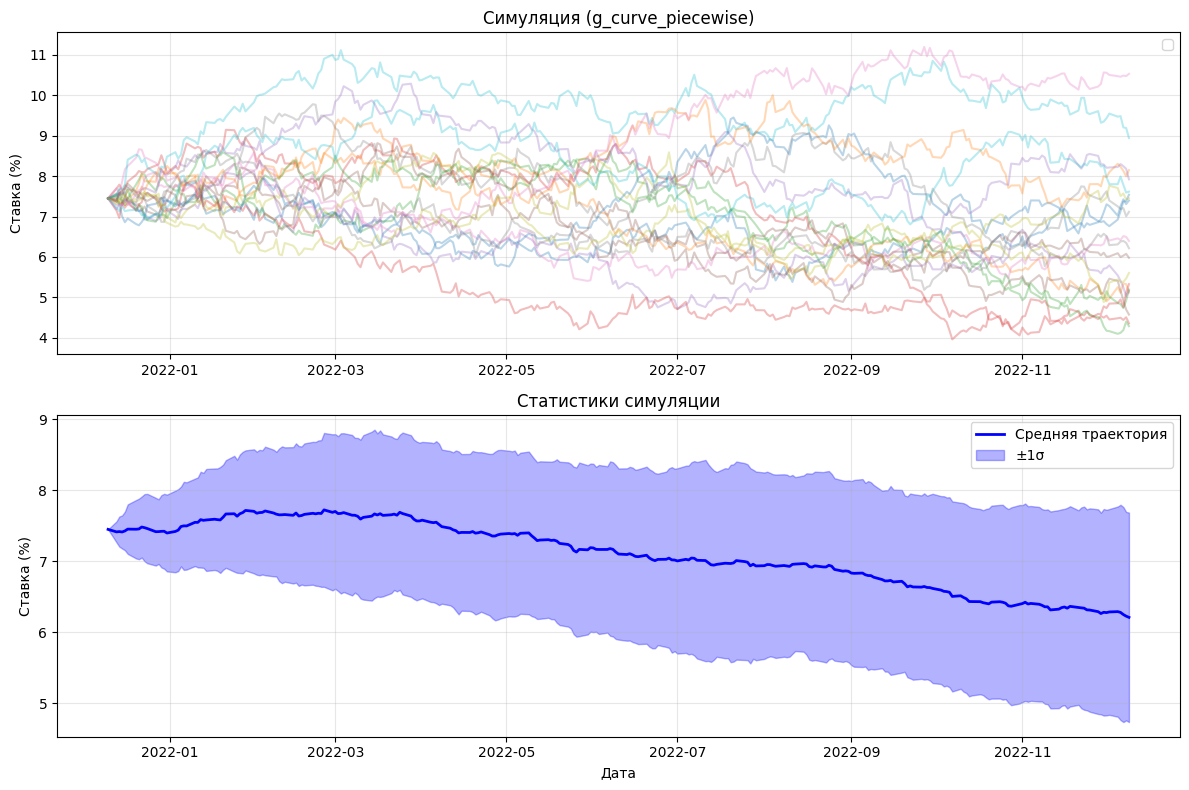

In [ ]:
# Калибровка
models = calibrate_models(ruonio_df["Rate"].values, mode="rub", g_curve_data=ru_g_curve_df)

# Симуляция для каждой модели
for model_type in models:
    print(f"\nСимуляция {model_type} модели...")
    model = create_model(models[model_type], model_type)
    dates, trajectories = simulate_model(
        model=model,
        initial_value=ruonio_initial,
        start_date=calc_date,
        end_date=end_date,
        n_paths=50,
        model_type="rate",
    )
    simulate_model(model, ruonio_initial, calc_date, end_date)
    plot_simulation(dates, trajectories, model_type, models[model_type])


СРАВНЕНИЕ МОДЕЛЕЙ
Постоянная θ: LogL = 3779.1301
  θ = 0.0059 (0.59%)

Построение графиков сравнения...


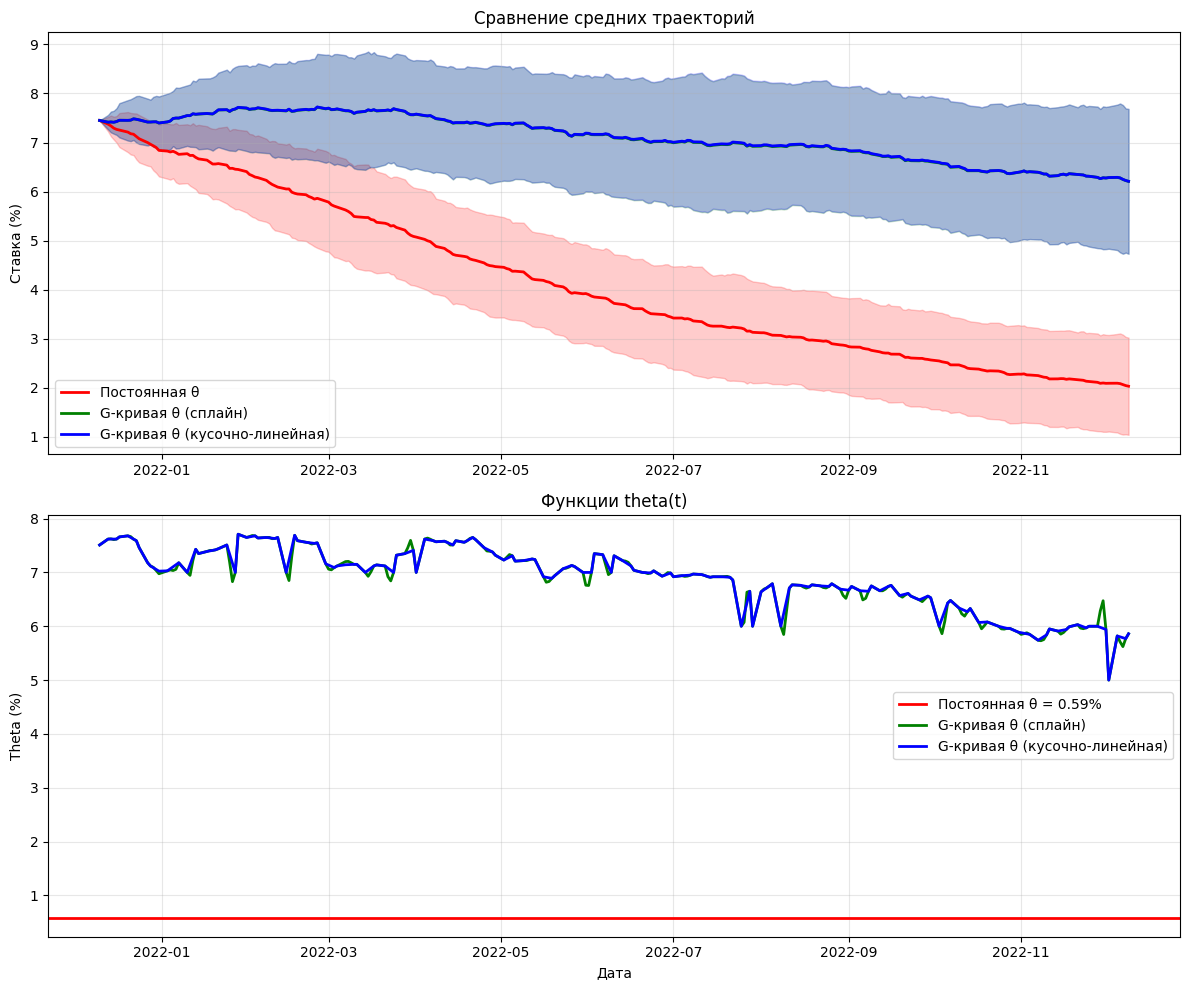

Ошибка: модель типа 'None' не найдена в словаре models
Доступные модели: ['constant', 'g_curve_spline', 'g_curve_piecewise']


In [ ]:
best_type = compare_models(models, ruonio_initial, calc_date, end_date)
print_best_params(models, best_type)

СТАТИСТИКА ДАННЫХ (СТАВКА):
• Объем данных: 245 наблюдений
• Минимальный ставка: 6.8200 %
• Максимальный ставка: 21.2100 %
• Средний ставка: 10.4584 %
• Медиана: 8.2600 %
• Стандартное отклонение: 4.2025 %
• Коэффициент вариации: 0.4018

• 25-й перцентиль: 7.7400 %
• 75-й перцентиль: 10.7000 %
• IQR: 2.9600 %

Анализ изменений ставок:
• Среднее дневное изменение: 0.0004%
• Волатильность изменений: 0.7427%
• Макс. рост за день: 2.9600%
• Макс. падение за день: -10.0000%


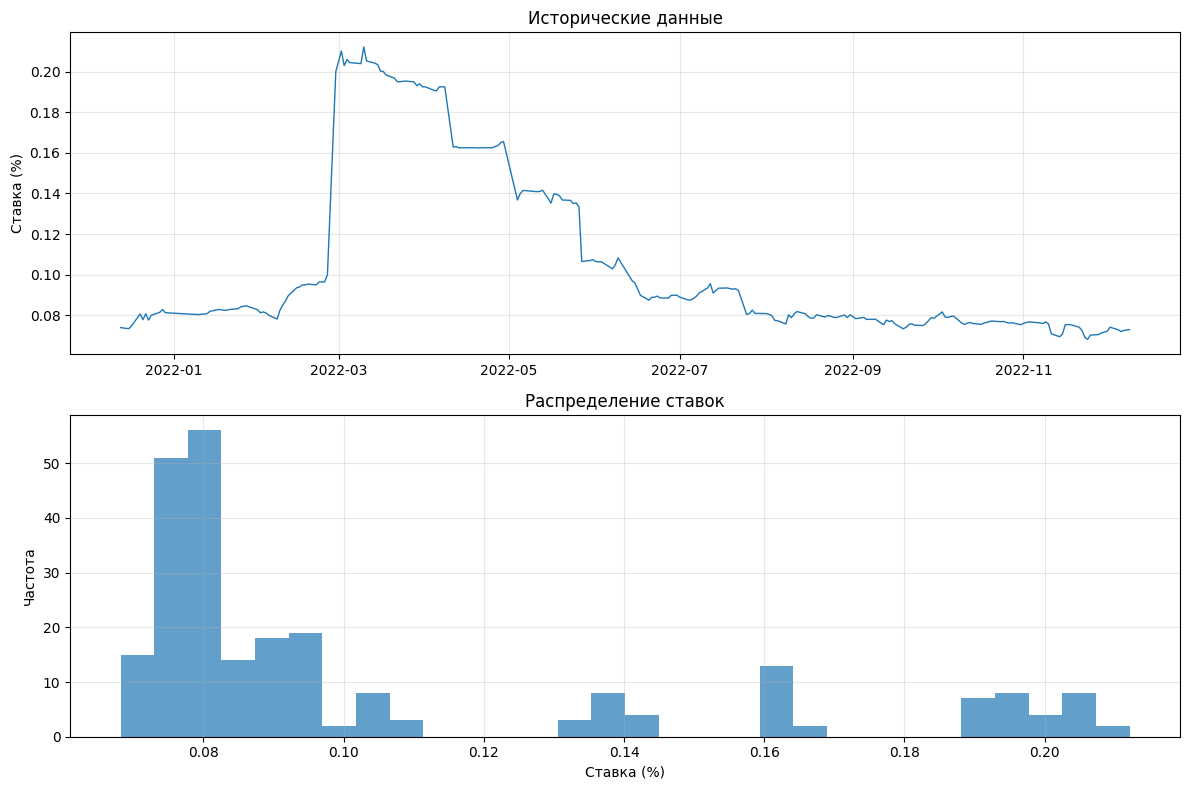

In [ ]:
# Фильтруем данные после нашей расчетной даты
ruonio_future = raw_ruonio_df[
    (raw_ruonio_df["Date"] > calc_date) & (raw_ruonio_df["Date"] <= end_date)
].copy()
ruonio_future = ruonio_future.dropna()
ruonio_future["Rate"] = ruonio_future["Rate"] / 100
print_statistics(ruonio_future["Rate"] * 100)
plot_historical_data(ruonio_future)

# RUB/USD

In [ ]:
fx_df = pd.read_excel("data/rub_usd.xlsx")
fx_df = fx_df.rename(columns={"data": "Date", "curs": "Rate"})
fx_df["Date"] = pd.to_datetime(fx_df["Date"])
fx_df = fx_df.sort_values("Date")

# Оставляем период до расчётной даты
calculation_date = pd.Timestamp("2021-12-10")
fx_hist = fx_df[(fx_df["Date"] >= start_date) & (fx_df["Date"] <= calculation_date)].copy()
fx_hist = fx_hist.dropna(subset=["Rate"])

# Берём начальный курс S0 на дату 10.12.2021
fx_initial = fx_hist[fx_hist["Date"] == calculation_date]["Rate"].values[0]
print(f"Начальный курс на {calculation_date.date()}: {fx_initial:.4f} RUB за 1 USD")

Начальный курс на 2021-12-10: 73.5998 RUB за 1 USD


In [ ]:
# Расчет лог-доходностей
fx_hist["LogRate"] = np.log(fx_hist["Rate"])
fx_hist["LogReturn"] = fx_hist["LogRate"].diff()
log_returns = fx_hist["LogReturn"].dropna()

In [ ]:
print_statistics(fx_hist["Rate"], data_type="fx", log_returns=log_returns)

СТАТИСТИКА ДАННЫХ (КУРС):
• Объем данных: 738 наблюдений
• Минимальный курс: 60.9474 RUB/USD
• Максимальный курс: 80.8815 RUB/USD
• Средний курс: 70.0776 RUB/USD
• Медиана: 71.7492 RUB/USD
• Стандартное отклонение: 4.9780 RUB/USD
• Коэффициент вариации: 0.0710

• 25-й перцентиль: 65.0605 RUB/USD
• 75-й перцентиль: 73.9897 RUB/USD
• IQR: 8.9293 RUB/USD

Анализ изменений курса:
• Среднее дневное изменение: 0.0001
• Волатильность изменений: 0.0077
• Макс. рост за день: 0.0646
• Макс. падение за день: -0.0350


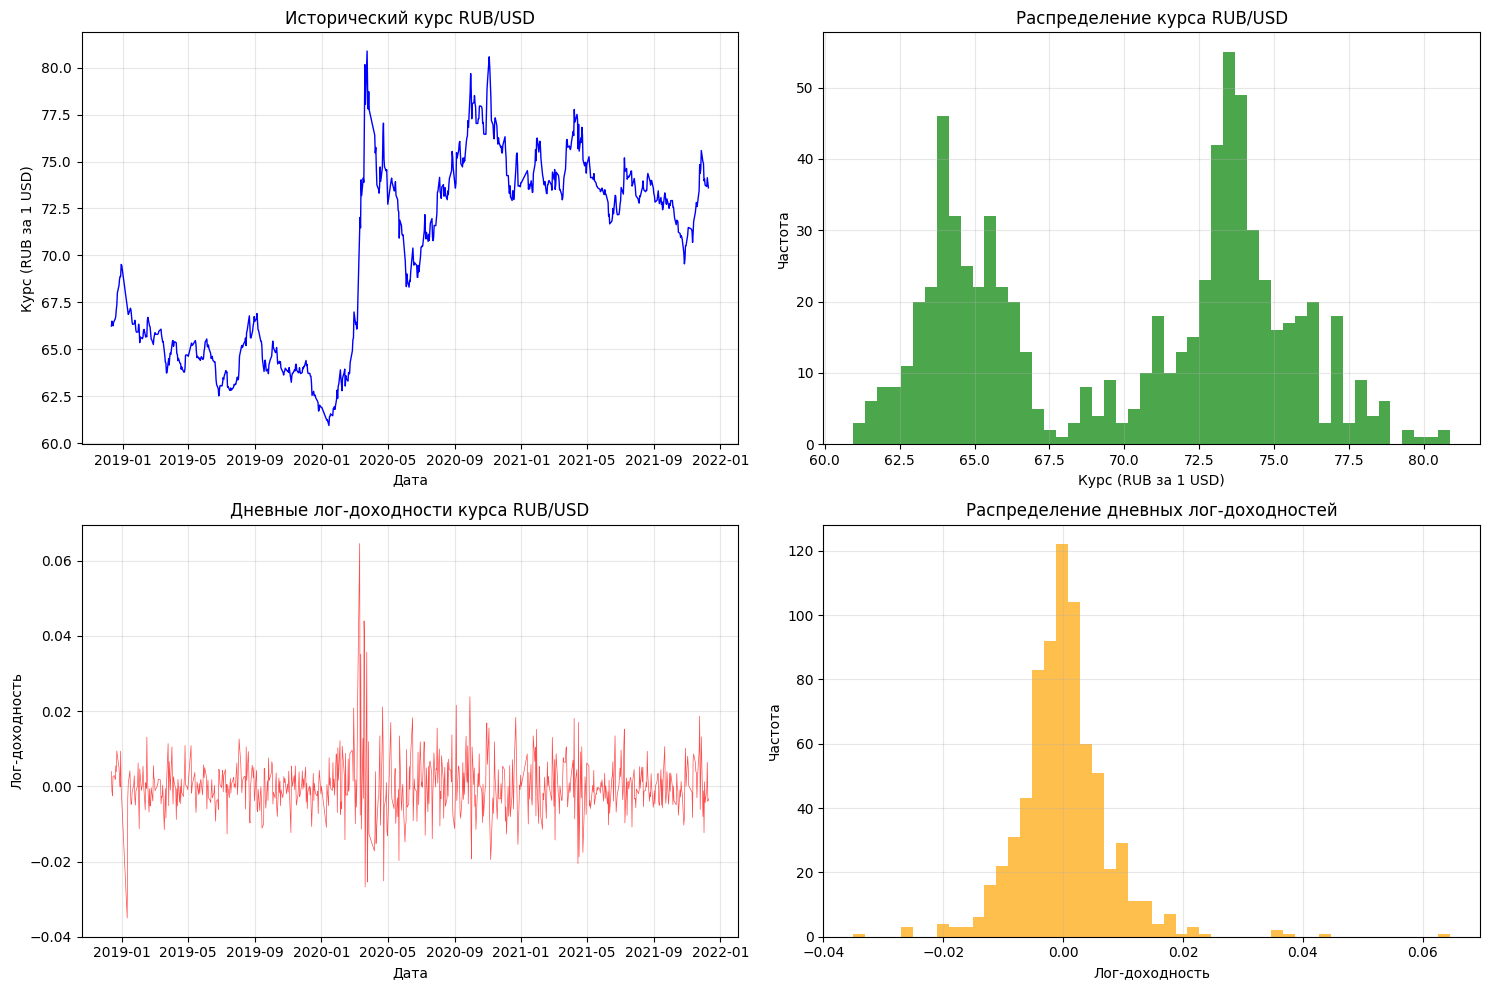

In [ ]:
plot_fx_analysis(fx_hist, log_returns)

In [ ]:
fx_params = calibrate_fx_model(log_returns)
fx_model = create_model(fx_params, "fx")
dates_fx_simple, trajectories_fx_simple = simulate_model(
    model=fx_model,
    initial_value=fx_initial,
    start_date=calc_date,
    end_date=end_date,
    n_paths=50,
    model_type="fx",
    mu_annual=fx_params["mu_annual"],
)



Калибровка FX модели...
   μ_дневной=0.000143, σ_дневной=0.007697
   μ_годовой=0.036016, σ_годовой=0.122183


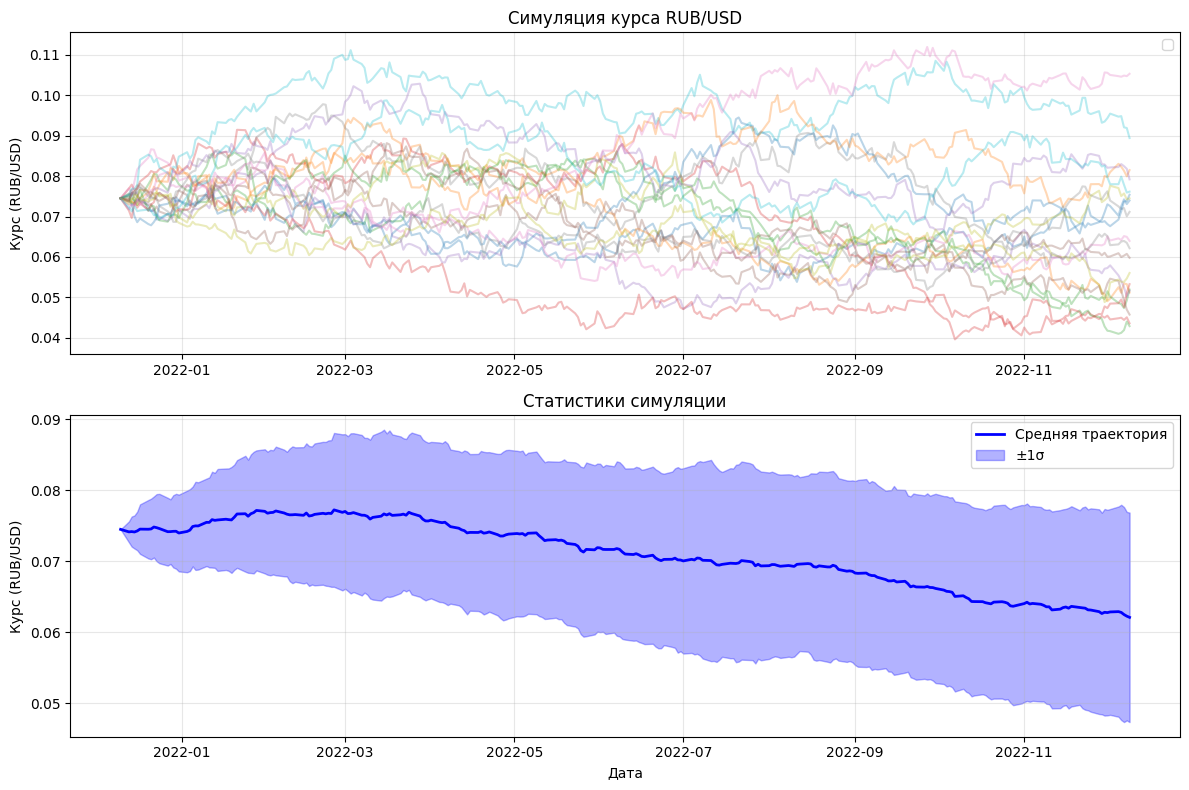

In [ ]:
plot_simulation(
    dates=dates,
    trajectories=trajectories,
    model_type="fx",
    title="Симуляция курса RUB/USD",
    asset_type="fx",
)